In [2]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

# Abstract

--- enter here ---

# Implementation Check

In [`perceptron.py`](https://github.com/lawolff1702/lawolff1702.github.io/blob/9deacaec063f8c0fe40ae8cff36eb517f0f4829d/posts/Implementing%20the%20Perceptron%20Algorithm/perceptron.py), we implement the perceptron algorithm using...

Below we are using Professor Chodrow's [functions](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration) to generate and visualize linearly separable data to test our implementation.

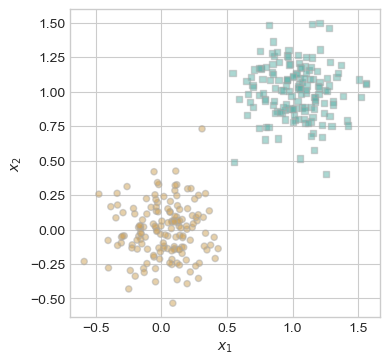

In [ ]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

As we can observe we have generated a set of linearly separable data that our perceptron should be able to separate with 100% accuracy (equivalent to 0 loss)

In [4]:
from perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

loss

tensor(0.)

Great! It worked, we have a perceptron that minimizes our loss to zero! We can see below the step by step process as the perceptron algorithm iteratively finds the line that separates the squares and the circles.

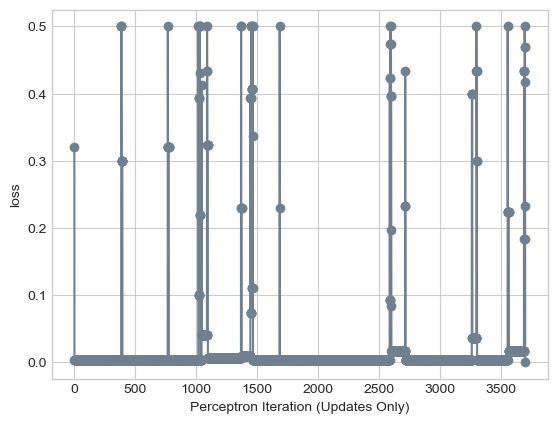

In [5]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Here is the line we found:

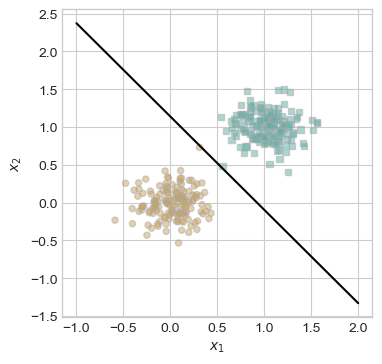

In [6]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")

# Experiments

Let us delve into how we arrived to this line iteratively on two dimensional data. First, we are going to have a look at a situation where we know our data is *linearly separable*. We are going to explore this with a slightly modified function from the [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration).

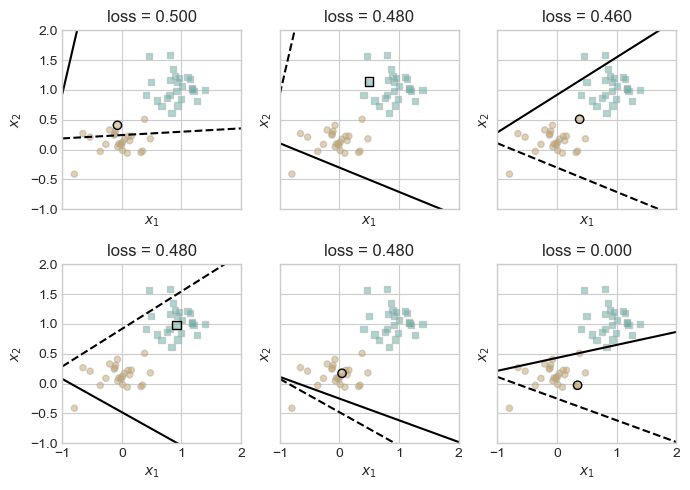

In [15]:
torch.manual_seed(3141)
X, y = perceptron_data(n_points=50, noise=0.3)
n = X.shape[0]

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

plot_data = []
loss_vec = []

loss = 1
while loss > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)
        plot_data.append((old_w, torch.clone(p.w), i, loss))


plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex=True, sharey=True)
markers = ["o", ","]
marker_map = {-1: 0, 1: 1}

plot_data = plot_data[-6:]

for current_ax, (old_w, new_w, i, loss) in enumerate(plot_data):
    ax = axarr.ravel()[current_ax]
    plot_perceptron_data(X, y, ax)
    draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
    draw_line(new_w, x_min=-1, x_max=2, ax=ax, color="black")
    ax.scatter(X[i, 0], X[i, 1], color="black", facecolors="none", edgecolors="black", 
               marker=markers[marker_map[2 * (y[i].item()) - 1]])
    ax.set_title(f"loss = {loss:.3f}")
    ax.set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()

The above figure shows the last six iterations of the perceptron as it is adjusts the weights based on local loss on data that we know is linearly separable. What is interesting to not here is that the line is not narrowly converging towards a loss of zero but rather, adjusts for each point without respect to the whole. The result of this method is that our loss seemingly jumps around in directions that may seem counter intuitive until we reach our loss of zero and terminate.

The graph below illustrates this quite well:

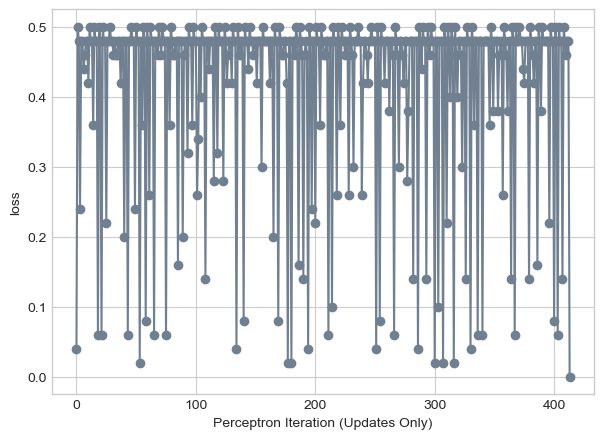

In [14]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This is all nice and dandy when we have access to linearly separable data, but what about when our data is **not** linearly separable. In such a case, it is impossible to have a loss of zero. So we will implement a maximum number of iterations so that our code doesn't run forever to no avail.

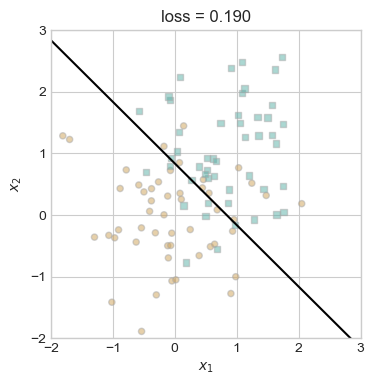

In [30]:
torch.manual_seed(124816)
X, y = perceptron_data(n_points=100, noise=0.8)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000 # Maximum number of iterations
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

In the figure above we can observe first that our data is not linearly separable, and thus even after 1000 iterations we achieved a loss of 0.19, which is not terrible, but not zero.

Below we can see the evolution of the loss over these iterations, and note that there is not point with loss zero/

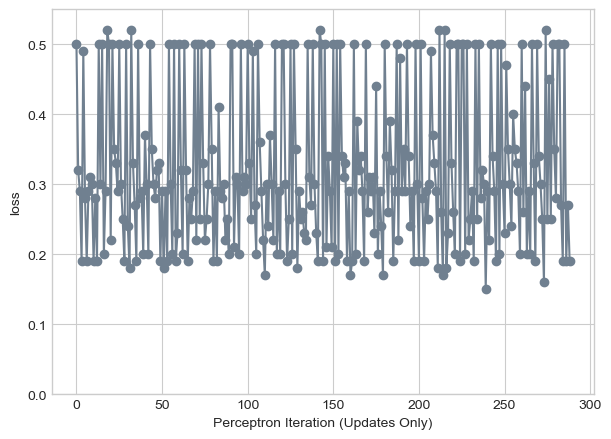

In [35]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, 0.55)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

With non linearly separable data we can also see that in some cases our loss can be above 50% misclassified for certain lines. In addition, our final iteration was not a representation of the best we could get, rather where we were after 1000 iterations. We can see that in earlier updates we achieved closer to 15% misclassified.

Thus far we have only been working with two dimensional data, however the perceptron algorithm works with higher dimensional data! Below we are going to run the algorithm on a data set with seven dimensions and observe the evolution of the loss as we iterate.

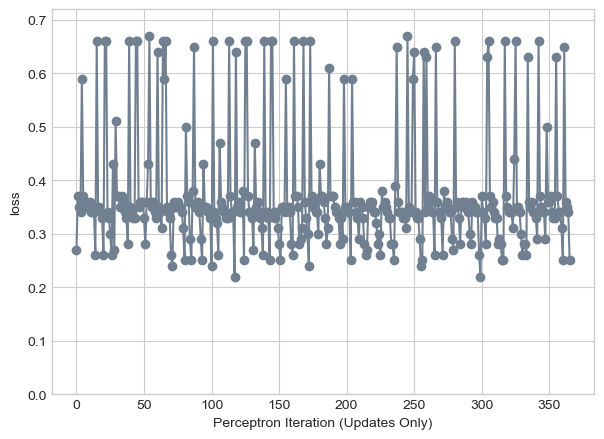

In [52]:
torch.manual_seed(2003)
X, y = perceptron_data(n_points=100, noise=0.5, p_dims=7)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000 # Maximum number of iterations
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, max(loss_vec) + 0.05)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We can see that over 1000 iterations our loss never reached zero. We can also note somewhat of a plateau of points around 0.35 that we would lead me to believe that the data is not linearly separable. We can have linearly separable data in seven dimensions as illustrated below.

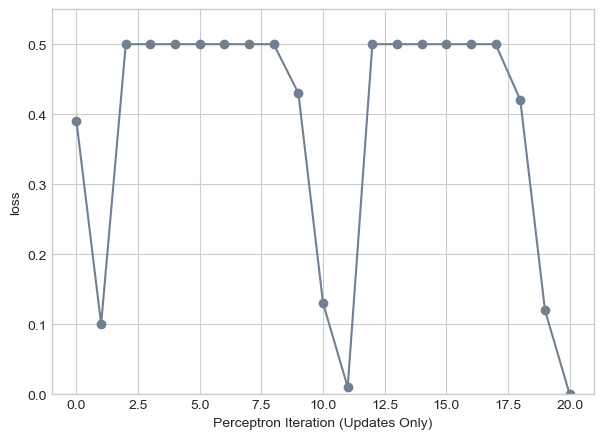

In [54]:
torch.manual_seed(2003)
X, y = perceptron_data(n_points=100, noise=0.07, p_dims=7)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000 # Maximum number of iterations
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, max(loss_vec) + 0.05)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As we can see, in the end we do achieve a loss score of zero indicating we can accurately separate and classify the different sorts of points with a hyperplane of sorts in $\mathbb{R}^7$. This data was achieved by simply turning down the noise parameter when we generate points.

# Minibatch Perceptron